# Project for "Wikishop"

The online store "Wikishop" is launching a new service. Now users can edit and supplement product descriptions, just like in wiki communities. That is, customers offer their edits and comment on others' changes. The store needs a tool that will search for toxic comments and send them for moderation. 

We need to train the model to classify comments into positive and negative. We have a data set with markup about the toxicity of edits.

Let's build a model with the value of quality metric *F1* at least 0.75.

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model training</a></span></li><li><span><a href="#General-conclusion" data-toc-modified-id="General-conclusion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>General conclusion</a>

## Data preprocessing

Import the necessary libraries for further work:

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
try:
    data = pd.read_csv(r'C:\Users\Julia\Desktop\DATA_SCIENCE\Datasets\toxic_comments.csv', index_col=[0])
except:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])

Let's check the data for duplicates, missing values, display general dataframe information and look at the first 5 lines using the `head()` method.

In [3]:
def show (data):
    print('Duplicates:', data.duplicated().sum())
    print()
    print('Missing values:\n', data.isna().sum())
    print()
    print('Table size:', data.shape)
    print()
    data.info()
    return data.head()
show(data)

Duplicates: 0

Missing values:
 text     0
toxic    0
dtype: int64

Table size: (159292, 2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Special characters were found in the comments. Let's clear them using regular expressions and lemmatize them:

In [4]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z ]+", " ", text)
    return text.strip().lower()

In [5]:
wnl = WordNetLemmatizer()
tknzr = TweetTokenizer()
def lemmatize(text, m=wnl):
    word_list = tknzr.tokenize(text)
    lemma_list = []
    for word, tag in nltk.pos_tag(word_list):
        if tag.startswith('NN'):
            lemma = m.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            lemma = m.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            lemma = m.lemmatize(word, pos='a')
        elif tag.startswith('R'):
            lemma = m.lemmatize(word, pos='r')
        else:
            lemma = m.lemmatize(word)
        lemma_list.append(lemma)
    return ' '.join(lemma_list)

data['text'] = data['text'].apply(clean_text)
data['text'] = data['text'].apply(lemmatize)
data.head()

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Let's look at the distribution of the target `toxic`:

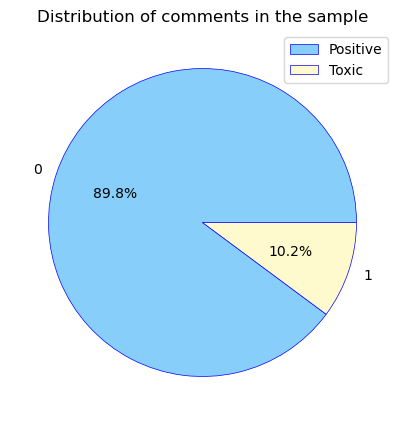

In [6]:
data['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6.5,5), colors=['#87CEFA', '#FFFACD'],
                                 wedgeprops={'edgecolor': 'blue', 'linewidth': 0.5})
plt.legend(['Positive','Toxic'])
plt.title('Distribution of comments in the sample')
plt.axis('off');

There is an imbalance in the sample. There are more positive comments (90%) than negative ones (10%).

**Conclusion:**
- we imported the required libraries for further work and loaded the data
- we checked the data for duplicates and missing values, printed general information about the dataframe, no duplicates or missing values were found
- special symbols were found in the comments, cleaned them up using regular expressions and lemmatized
- looked at the distribution of the target `toxic` and found that there is an imbalance in the sample: there are more positive comments (90%) than negative (10%)

## Model training

Let's divide the sample into training and test samples in the ratio of 90/10 , keep the proportions of the target variable in the training and test samples when dividing the data using the `stratify` parameter:

In [7]:
features = data['text']
target = data['toxic']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1,
                                                                            random_state=123, stratify=data.toxic)
print(f'Training sample size: {len (features_train) / len(data):.0%}')
print(f'Test sample size: {len (features_test) / len(data):.0%}')

Training sample size: 90%
Test sample size: 10%


Set `stop_words` set to remove from the text, also set ngram_range to create n-grams of the text. Convert the text data to a matrix using the TF-IDF weighting scheme:

In [8]:
stop_words = set(stopwords.words('english'))
tfv = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1))

Let's get down to model training:

In [9]:
tfv_lr_pipeline = Pipeline([('tfv', tfv),
                            ('lr', LogisticRegression(random_state=123))])
params_tfv_lr = {'lr__class_weight': ['balanced'],
                 'lr__C': [10],
                 'lr__max_iter': [500]}

grid_tfv_lr = GridSearchCV(tfv_lr_pipeline, param_grid=params_tfv_lr, scoring='f1', verbose=3, cv=5, n_jobs=-1)
grid_tfv_lr.fit(features_train, target_train)
print('The best Logistic Regression parameters on cross-validation sampling:', grid_tfv_lr.best_params_)
print('F1:', round(grid_tfv_lr.best_score_, 5))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
The best Logistic Regression parameters on cross-validation sampling: {'lr__C': 10, 'lr__class_weight': 'balanced', 'lr__max_iter': 500}
F1: 0.75564


In [10]:
tfv_sgd_pipeline = Pipeline([('tfv', tfv),
                             ('sgd', SGDClassifier(random_state=123))])

params_tfv_sgd = {'sgd__class_weight': ['balanced', None],
                  'sgd__max_iter': [500, 1000],
                  'sgd__loss': ['log', 'squared_hinge'],
                  'sgd__penalty': ['l1'],
                  'sgd__shuffle': [True],
                  'sgd__n_iter_no_change': [10, 20]}

grid_tfv_sgd = GridSearchCV(tfv_sgd_pipeline, param_grid=params_tfv_sgd, scoring='f1', verbose=3, cv=5, n_jobs=-1)
grid_tfv_sgd.fit(features_train, target_train)
print('The best SGD Classifier parameters on cross-validation sampling:', grid_tfv_sgd.best_params_)
print('F1:', round(grid_tfv_sgd.best_score_, 5))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
The best SGD Classifier parameters on cross-validation sampling: {'sgd__class_weight': 'balanced', 'sgd__loss': 'log', 'sgd__max_iter': 500, 'sgd__n_iter_no_change': 20, 'sgd__penalty': 'l1', 'sgd__shuffle': True}
F1: 0.71491


The best result of the f1 metric on the cross-validation sample was shown by the logistic regression model, let's check its quality on the test sample:

In [11]:
prediction = grid_tfv_lr.predict(features_test)
print('F1 for Logisctic Regression on the test sample:', round(f1_score(target_test, prediction), 5))

F1 for Logisctic Regression on the test sample: 0.76628


Let's analyze the results of model classification using the confusion matrix:

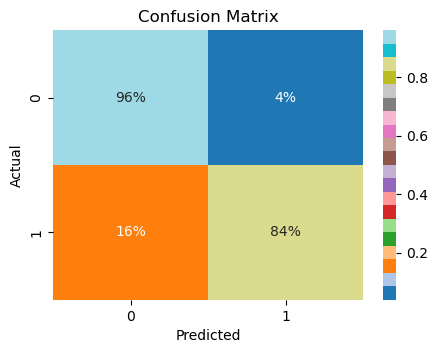

In [12]:
plt.figure(figsize=(5,3.5))
ax = plt.subplot()
sns.heatmap(confusion_matrix(target_test, prediction, normalize='true'), annot=True, fmt='.0%', cmap="tab20")
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix');

False Positive and False Negative differ, but the differences are not critical, the percentage of correctly predicted values is quite high

**Conclusion:**
- Divided the sample into training and test samples in the ratio of 80/20 , kept the proportions of the target variable in the training and test samples when dividing the data using the `stratify` parameter
- converted the data type of column text to Unicode (U) type
- set stop_words to delete from text, also set ngram_range to create n-grams of text
- converted the text data into vectors using the TF-IDF weighting scheme. ngram_range=(1,2) allowed using vectorization considering both separate words and two words (bigrams) in the text, which helped to take into account the context and semantic relationships between words
- we have trained Logistic Regression and SGDClassifier models, the best result of f1 metric on the cross-validation sample was shown by Logistic Regression model, we checked its quality on the test sample, the result of F1 for Logisctic Regression on the test sample is 0.76628
- we analyzed the model classification results using the error matrix and found out that False Positive and False Negative differ, but the differences are not critical, the percentage of correctly predicted values is quite high

## General conclusion

- we downloaded, analyzed, and prepared the data
- divided the sample into training and test ones, set stop_words to remove from the text, also set ngram_range to create n-grams of text, converted text data into vectors using TF-IDF weighting scheme
- we have trained Logistic Regression and SGDClassifier models for classification, the best result of f1 metric on the cross-validation sample was shown by Logistic Regression model, we checked its quality on the test sample, the result of F1 for Logistic Regression on the test sample is 0.76628
- we analyzed the results of model classification using the error matrix.
- The result f1 for the Logisctic Regression on the test sample is 0.76628, which satisfies the condition of the problem